In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v8_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v8_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [3]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0,1,-1,0,1,-1,-1,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,212.0,364.0,40.0,3.0,1.0,1.0,4,6,8,11,335580,36215,13849,13529,881,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037868,0.036485
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0,2,-1,0,1,-1,-1,0,0,76.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,4,6,8,11,335580,36215,13849,13529,785,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041860,0.040170
2,000104bdffaaad1a1e0a9ebacf585f33,902,0,3,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,4,6,8,11,335580,36215,13849,13529,675,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041742,0.040073
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0,4,-1,0,1,-1,-1,0,0,111.0,1.0,0,1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,134.0,1114.0,143.0,16.0,12.0,12.0,4,6,8,11,335580,36215,13849,13529,671,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.032967,0.031939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,0,5,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,4,6,8,11,335580,36215,13849,13529,911,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037037,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.017964,0.017748
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.018450,0.018177
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.035605,0.034342,0.022624,0.022163
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b0

In [4]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


### CatBoost Ranker

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score
from catboost import CatBoostRanker, Pool

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad', 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no')] # seen_yadも入れる 
cat_cols = ['yado_no']+ ['label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd'] 
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# CatBoost のパラメータ
params = {
    'loss_function': 'YetiRank',  # YetiRankPairwise という選択肢もあります
    'learning_rate': 0.2,
    'iterations': 5000,
    'depth': 6,
    'random_seed': 42531,
    "cat_features": cat_cols,
    'task_type': 'GPU',  # GPUを使用するための設定
}

In [6]:
map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # データセットの作成
    train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids], cat_features=cat_cols)
    val_pool = Pool(data=valid_data[features], label=valid_data[target], group_id=valid_data[query_ids], cat_features=cat_cols)

    # モデルの訓練
    model = CatBoostRanker(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(val_pool)
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存

    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')


Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1958218	best: 0.1958218 (0)	total: 121ms	remaining: 10m 6s
1:	test: 0.2086896	best: 0.2086896 (1)	total: 230ms	remaining: 9m 34s
2:	test: 0.2084480	best: 0.2086896 (1)	total: 341ms	remaining: 9m 28s
3:	test: 0.2115826	best: 0.2115826 (3)	total: 452ms	remaining: 9m 24s
4:	test: 0.2118471	best: 0.2118471 (4)	total: 559ms	remaining: 9m 18s
5:	test: 0.2139164	best: 0.2139164 (5)	total: 667ms	remaining: 9m 15s
6:	test: 0.2149160	best: 0.2149160 (6)	total: 780ms	remaining: 9m 16s
7:	test: 0.2149274	best: 0.2149274 (7)	total: 888ms	remaining: 9m 14s
8:	test: 0.2149184	best: 0.2149274 (7)	total: 999ms	remaining: 9m 13s
9:	test: 0.2169964	best: 0.2169964 (9)	total: 1.11s	remaining: 9m 12s
10:	test: 0.2169522	best: 0.2169964 (9)	total: 1.22s	remaining: 9m 11s
11:	test: 0.2172722	best: 0.2172722 (11)	total: 1.32s	remaining: 9m 10s
12:	test: 0.2172319	best: 0.2172722 (11)	total: 1.43s	remaining: 9m 9s
13:	test: 0.2172356	best: 0.2172722 (11)	total: 1.54s	remaining: 9m 10s
14:	test: 0.21

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1970875	best: 0.1970875 (0)	total: 116ms	remaining: 9m 38s
1:	test: 0.1974409	best: 0.1974409 (1)	total: 224ms	remaining: 9m 19s
2:	test: 0.1974508	best: 0.1974508 (2)	total: 333ms	remaining: 9m 14s
3:	test: 0.2115462	best: 0.2115462 (3)	total: 439ms	remaining: 9m 8s
4:	test: 0.2118056	best: 0.2118056 (4)	total: 550ms	remaining: 9m 9s
5:	test: 0.2130359	best: 0.2130359 (5)	total: 657ms	remaining: 9m 6s
6:	test: 0.2157502	best: 0.2157502 (6)	total: 767ms	remaining: 9m 7s
7:	test: 0.2163253	best: 0.2163253 (7)	total: 876ms	remaining: 9m 6s
8:	test: 0.2172838	best: 0.2172838 (8)	total: 985ms	remaining: 9m 6s
9:	test: 0.2185879	best: 0.2185879 (9)	total: 1.09s	remaining: 9m 5s
10:	test: 0.2192105	best: 0.2192105 (10)	total: 1.2s	remaining: 9m 5s
11:	test: 0.2193998	best: 0.2193998 (11)	total: 1.31s	remaining: 9m 4s
12:	test: 0.2197261	best: 0.2197261 (12)	total: 1.42s	remaining: 9m 3s
13:	test: 0.2196832	best: 0.2197261 (12)	total: 1.52s	remaining: 9m 3s
14:	test: 0.2196583	best

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1942960	best: 0.1942960 (0)	total: 125ms	remaining: 10m 24s
1:	test: 0.2013563	best: 0.2013563 (1)	total: 247ms	remaining: 10m 16s
2:	test: 0.2118799	best: 0.2118799 (2)	total: 362ms	remaining: 10m 2s
3:	test: 0.2119562	best: 0.2119562 (3)	total: 474ms	remaining: 9m 52s
4:	test: 0.2121923	best: 0.2121923 (4)	total: 592ms	remaining: 9m 51s
5:	test: 0.2123699	best: 0.2123699 (5)	total: 703ms	remaining: 9m 45s
6:	test: 0.2136209	best: 0.2136209 (6)	total: 815ms	remaining: 9m 41s
7:	test: 0.2147540	best: 0.2147540 (7)	total: 928ms	remaining: 9m 39s
8:	test: 0.2148292	best: 0.2148292 (8)	total: 1.05s	remaining: 9m 40s
9:	test: 0.2160702	best: 0.2160702 (9)	total: 1.16s	remaining: 9m 39s
10:	test: 0.2171138	best: 0.2171138 (10)	total: 1.28s	remaining: 9m 40s
11:	test: 0.2175798	best: 0.2175798 (11)	total: 1.39s	remaining: 9m 39s
12:	test: 0.2176846	best: 0.2176846 (12)	total: 1.51s	remaining: 9m 38s
13:	test: 0.2180773	best: 0.2180773 (13)	total: 1.63s	remaining: 9m 39s
14:	test: 

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1965132	best: 0.1965132 (0)	total: 122ms	remaining: 10m 11s
1:	test: 0.1998790	best: 0.1998790 (1)	total: 238ms	remaining: 9m 55s
2:	test: 0.1998967	best: 0.1998967 (2)	total: 349ms	remaining: 9m 41s
3:	test: 0.2034671	best: 0.2034671 (3)	total: 459ms	remaining: 9m 33s
4:	test: 0.2125368	best: 0.2125368 (4)	total: 571ms	remaining: 9m 30s
5:	test: 0.2124993	best: 0.2125368 (4)	total: 684ms	remaining: 9m 28s
6:	test: 0.2127397	best: 0.2127397 (6)	total: 798ms	remaining: 9m 29s
7:	test: 0.2132324	best: 0.2132324 (7)	total: 912ms	remaining: 9m 29s
8:	test: 0.2143138	best: 0.2143138 (8)	total: 1.03s	remaining: 9m 30s
9:	test: 0.2149869	best: 0.2149869 (9)	total: 1.14s	remaining: 9m 30s
10:	test: 0.2169851	best: 0.2169851 (10)	total: 1.25s	remaining: 9m 29s
11:	test: 0.2169405	best: 0.2169851 (10)	total: 1.36s	remaining: 9m 27s
12:	test: 0.2178850	best: 0.2178850 (12)	total: 1.48s	remaining: 9m 27s
13:	test: 0.2181536	best: 0.2181536 (13)	total: 1.59s	remaining: 9m 27s
14:	test: 0

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1987219	best: 0.1987219 (0)	total: 116ms	remaining: 9m 40s
1:	test: 0.1987200	best: 0.1987219 (0)	total: 228ms	remaining: 9m 29s
2:	test: 0.2135716	best: 0.2135716 (2)	total: 338ms	remaining: 9m 22s
3:	test: 0.2145455	best: 0.2145455 (3)	total: 444ms	remaining: 9m 14s
4:	test: 0.2148662	best: 0.2148662 (4)	total: 551ms	remaining: 9m 10s
5:	test: 0.2149297	best: 0.2149297 (5)	total: 659ms	remaining: 9m 8s
6:	test: 0.2163675	best: 0.2163675 (6)	total: 764ms	remaining: 9m 5s
7:	test: 0.2167224	best: 0.2167224 (7)	total: 874ms	remaining: 9m 5s
8:	test: 0.2173761	best: 0.2173761 (8)	total: 981ms	remaining: 9m 3s
9:	test: 0.2175800	best: 0.2175800 (9)	total: 1.09s	remaining: 9m 3s
10:	test: 0.2185562	best: 0.2185562 (10)	total: 1.19s	remaining: 9m 1s
11:	test: 0.2204416	best: 0.2204416 (11)	total: 1.3s	remaining: 9m
12:	test: 0.2204659	best: 0.2204659 (12)	total: 1.41s	remaining: 9m
13:	test: 0.2209566	best: 0.2209566 (13)	total: 1.52s	remaining: 9m
14:	test: 0.2213253	best: 0.221

              Feature Id  Importances
0             predict_no     0.027366
1          count_yado_no     0.011086
2        TE_yado_no_mean     0.008294
3             max_seq_no     0.006610
4         TE_yado_no_var     0.003648
5         total_room_cnt     0.002251
6         TE_sml_cd_mean     0.001962
7           overall_rank     0.001778
8                yado_no     0.001730
9            sml_cd_rank     0.000461
10             onsen_flg     0.000365
11           wid_cd_rank     0.000332
12           ken_cd_rank     0.000315
13           lrg_cd_rank     0.000213
14        TE_ken_cd_mean     0.000176
15         TE_sml_cd_var     0.000131
16          label_sml_cd     0.000120
17           kd_stn_5min     0.000115
18         TE_wid_cd_var     0.000107
19          count_ken_cd     0.000100
20     kd_conv_walk_5min     0.000094
21            popularity     0.000080
22          count_sml_cd     0.000063
23        TE_lrg_cd_mean     0.000058
24      wireless_lan_flg     0.000055
25          

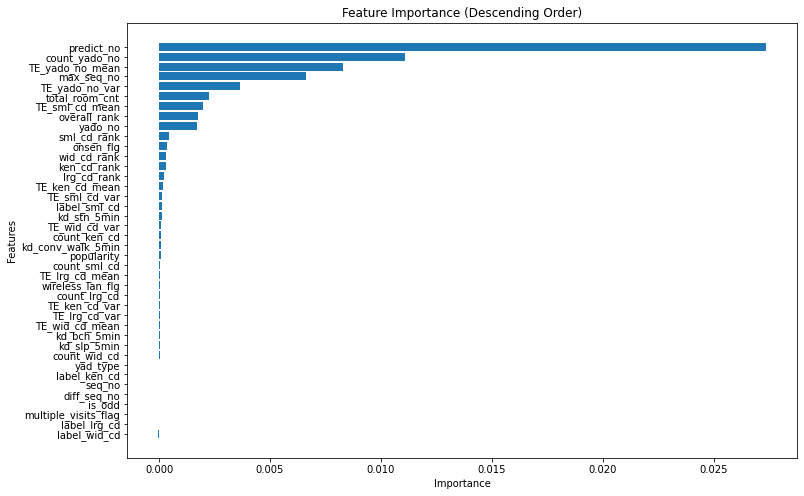

In [7]:
import matplotlib.pyplot as plt

# トレーニングデータセットでのPoolを作成（もしまだ作成していない場合）
#train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids])

# 特徴量の重要度を取得（トレーニングデータセットを使用）
feature_importances = model.get_feature_importance(train_pool, prettified=True)

# 特徴量の重要度を降順に並び替え
feature_importances.sort_values(by='Importances', ascending=False, inplace=True)

# 特徴量の重要度を表示
print(feature_importances)

# 特徴量の重要度をグラフで表示（降順）
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.gca().invert_yaxis()  # y軸を逆順にして、重要度が高い特徴量を上に表示
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Descending Order)')
plt.show()



In [8]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [9]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.160776
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.168737
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.329549
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.081843
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.087919


In [10]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.160776
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.168737
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.329549
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.081843
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.087919
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.260966
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.285094
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.503149
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.915571


In [11]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.160776
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.168737
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.329549
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.081843
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.087919
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.260966
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.285094
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.503149
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.915571


In [12]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/catRanker_ver5_oof_pred.csv', index=False)

In [13]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.160776
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.168737
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.329549
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.081843
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.087919
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.260966
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.285094
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.503149
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.915571


### CVの計算

In [14]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [15]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [16]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 902, 7749, 11380, 1284, 12491, 5490, 254, 4072]
CPU times: user 152 ms, sys: 3.92 ms, total: 156 ms
Wall time: 156 ms


In [17]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:45<00:00, 6296.90it/s]


In [18]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,997,12846,5289,3324,11882,9208,9207,9209
1,8253,4488,2570,1586,8747,11104,2259,3725,3564,8225
2,4863,5238,13642,2957,9039,4355,1967,6722,7509,11724
3,626,2272,13549,755,109,7812,11715,1341,13296,7872
4,96,3894,902,7749,11380,1284,12491,5490,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,10955,5719,13210,10522,13079,3725,1586,13717,8677,2876
288694,4767,963,2900,513,5299,8703,8465,6654,399,3940
288695,3566,4398,9558,7820,10364,2087,7308,4040,12240,844
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


### 要素の集合にバグがないかを確認

In [19]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [20]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムを確認する

In [21]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [22]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0          True
1          True
2          True
3          True
4          True
          ...  
288693     True
288694     True
288695     True
288696    False
288697     True
Length: 288698, dtype: bool
一致していない行：
285506


In [23]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [24]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,997,12846,5289,3324,11882,9208,9207,9209
1,8253,4488,2570,1586,8747,11104,2259,3725,3564,8225
2,4863,5238,13642,2957,9039,4355,1967,6722,7509,11724
3,626,2272,13549,755,109,7812,11715,1341,13296,7872
4,96,3894,902,7749,11380,1284,12491,5490,254,4072
5,4823,12544,10510,5369,9199,9207,9200,9201,1,9202
6,7531,4574,10442,10378,12774,441,7273,2480,13240,2282
7,111,4744,12464,10362,9508,12962,12125,1755,10544,7681
8,899,3802,3644,4014,1227,13220,12432,9723,13702,2164
9,10478,6592,379,3278,2806,3483,550,4303,9430,9773


In [25]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [26]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [27]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.46226465767984937


In [28]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [29]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [30]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,4101,2808,997,12846,5289,3324,11882,9208,9207,9209,False
1,8253,4488,2570,1586,8747,11104,2259,3725,3564,8225,False
2,4863,5238,13642,2957,9039,4355,1967,6722,7509,11724,False
3,626,2272,13549,755,109,7812,11715,1341,13296,7872,False
4,96,3894,902,7749,11380,1284,12491,5490,254,4072,False


### 推論用の候補テーブルを作成する

In [31]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [32]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[1.12043653 0.32894917 0.49277957 ... 0.05941929 0.02071809 0.24668761]
1683604


In [33]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(5, 1683604)


In [34]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [35]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,1.120437
1,00001149e9c73985425197104712478c,4714,0.328949
2,00001149e9c73985425197104712478c,2680,0.492780
3,00001149e9c73985425197104712478c,4420,-0.467421
4,00001149e9c73985425197104712478c,5466,-0.413553


In [36]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,1.120437
1,00001149e9c73985425197104712478c,4714,0.328949
2,00001149e9c73985425197104712478c,2680,0.492780
3,00001149e9c73985425197104712478c,4420,-0.467421
4,00001149e9c73985425197104712478c,5466,-0.413553
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.294597
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.191504
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.059419
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.020718


In [37]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,1.120437
1,00001149e9c73985425197104712478c,4714,0.328949
2,00001149e9c73985425197104712478c,2680,0.492780
3,00001149e9c73985425197104712478c,4420,-0.467421
4,00001149e9c73985425197104712478c,5466,-0.413553
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.294597
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.191504
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.059419
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.020718


In [38]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,1.120437
1,00001149e9c73985425197104712478c,4714,0.328949
2,00001149e9c73985425197104712478c,2680,0.492780
3,00001149e9c73985425197104712478c,4420,-0.467421
4,00001149e9c73985425197104712478c,5466,-0.413553
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.294597
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.191504
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.059419
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.020718


In [39]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/catRanker_ver5_test_pred.csv', index=False)

In [40]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [41]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[11723, 10729, 5623, 1891, 12767, 12620, 3781, 867, 11994, 634]
CPU times: user 95.6 ms, sys: 16 µs, total: 95.6 ms
Wall time: 95.7 ms


In [42]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:25<00:00, 6774.83it/s]


In [43]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,2680,4714,5466,4420,9830,9534,5785,6563
1,143,7014,613,8108,11923,6555,4066,6129,11237,12862
2,757,9190,7710,9910,1774,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,6489,10746
4,9020,10826,9623,3476,2862,3854,12029,5372,3844,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,10997,2278,9743,10042,3440
174696,3802,4014,13702,1227,899,9723,3644,12432,13220,2164
174697,12939,13719,13241,13797,7308,2087,5810,11037,8143,11796
174698,3100,10287,1687,2373,3002,2692,4976,13672,5513,12281


In [44]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [45]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [46]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [47]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)

0


In [48]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [49]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,11561,2680,4714,5466,4420,9830,9534,5785,6563,False
1,143,7014,613,8108,11923,6555,4066,6129,11237,12862,False
2,757,9190,7710,9910,1774,10485,6721,410,13570,6730,False
3,12341,3359,6991,1542,13521,5080,10861,4180,6489,10746,False
4,9020,10826,9623,3476,2862,3854,12029,5372,3844,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,10997,2278,9743,10042,3440,False
174696,3802,4014,13702,1227,899,9723,3644,12432,13220,2164,False
174697,12939,13719,13241,13797,7308,2087,5810,11037,8143,11796,False
174698,3100,10287,1687,2373,3002,2692,4976,13672,5513,12281,False


In [50]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/catRanker_ver5.csv', index=False)